## Семинар 4: "Сверточные сети"

ФИО: 

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    k = kernel[::-1]
    ks = len(k)
    for i in range(len(signal_convolved)):
        signal_convolved[i] = np.dot(signal[i:i+ks], k)
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

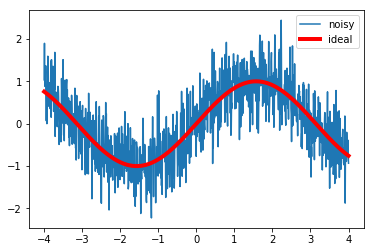

In [18]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [31]:
kernel_size = 5

In [32]:
denoised_signal = t_convolve(noisy_signal, (1/kernel_size,)*kernel_size)

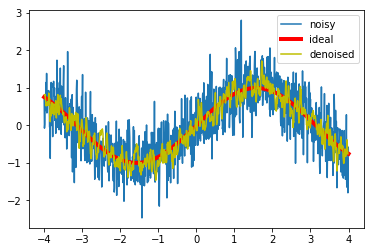

In [33]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[(kernel_size//2):-(kernel_size//2)], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [37]:
### YOUR CODE HERE #####
kernel_size = 101

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


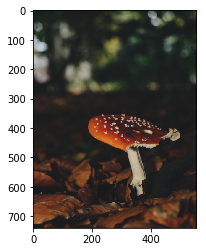

In [91]:
from scipy.misc import imresize
image = plt.imread('grib.jpeg')
image = imresize(image, 0.2)
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [92]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])[::-1]

bw_kernel = color_to_bw.reshape(1, 1, 3)

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

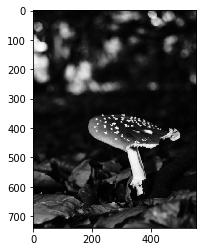

In [93]:
bw_image = convolve(image, bw_kernel, mode='valid')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image[:,:,0], cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

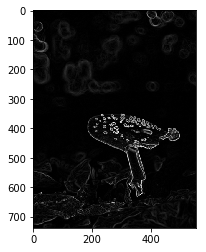

In [94]:
sobel_kernel = np.array([
        [-1, 0, +1],
        [-2, 0, +2],
        [-1, 0, +1],
])
sobel_image_x = convolve(bw_image[:,:,0], sobel_kernel, mode='valid')
sobel_image_y = convolve(bw_image[:,:,0], sobel_kernel.T, mode='valid')
sobel_image = np.sqrt(sobel_image_x ** 2 + sobel_image_y ** 2)
plt.imshow(sobel_image, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [101]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    ##### YOUR CODE HERE #####
    n_channels = kernel.shape[0]
    sh = list(signal.shape)
    sh[-1] = n_channels
    result = np.empty(sh)
    for i, k in enumerate(kernel):
        result[:,:,i] = convolve(signal, k, mode='valid')[:,:,0]
    return result.astype('uint8')

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [102]:
##### YOUR CODE HERE #####

rgb2bgr = np.array([ # N
    [[ # HW
        [1,0,0] # C (inverse?)
    ]],
    [[
        [0,1,0]
    ]],
    [[
        [0,0,1]
    ]],
])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

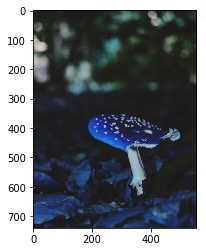

In [103]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

rgb2bgr_img = t_convolve_bank(image, rgb2bgr)
_img = t_convolve_bank(rgb2bgr_img, rgb2bgr)

plt.imshow(rgb2bgr_img)
# plt.imshow(_img)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [56]:
def maxpool(image):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    sh = list(image.shape)
    sh[0] //= 2
    sh[1] //= 2
    result = np.empty(sh)
    for h in range(image.shape[0]//2):
        for w in range(image.shape[1]//2):
            for c in range(image.shape[2]):
                result[h,w,c] = np.max(image[2*h:2*h+2, 2*w:2*w+2, c])
    return result.astype('uint8')

def medianpool(image):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    sh = list(image.shape)
    sh[0] //= 2
    sh[1] //= 2
    result = np.empty(sh)
    for h in range(image.shape[0]//2):
        for w in range(image.shape[1]//2):
            for c in range(image.shape[2]):
                result[h,w,c] = np.mean(image[2*h:2*h+2, 2*w:2*w+2, c])
    return result.astype('uint8')

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

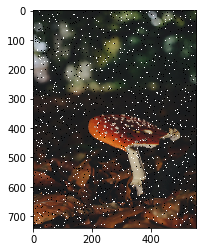

In [107]:
##### YOUR CODE HERE #####
# image_noised = (image + np.power(np.random.rand(*image.shape)*2.0 - 1.0, 50.0) * 255.0).astype('uint8')

N_dots = 10000
white_y = np.random.randint(0, image.shape[0], N_dots)
white_x = np.random.randint(0, image.shape[1], N_dots)

black_y = np.random.randint(0, image.shape[0], N_dots)
black_x = np.random.randint(0, image.shape[1], N_dots)

image_noised = image.copy()
image_noised[white_y, white_x] = [255, 255, 255]
image_noised[black_y, black_x] = [0, 0, 0]

plt.imshow(image_noised)

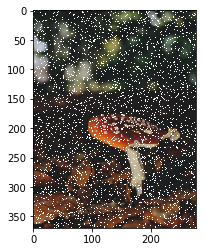

In [108]:
maxpooled = maxpool(image_noised)
plt.imshow(maxpooled)

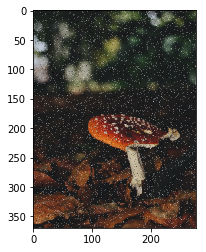

In [109]:
medianpooled = medianpool(image_noised)
plt.imshow(medianpooled)

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Усреднение работает лучше, т.к. среднее более устойчиво к выбросам, чем максимум.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data/mnist', train=True, download=False, transform=transform)
test_dataset = MNIST('../data/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
# пример сверточной сети

image_size = train_dataset.train_data.size(2)
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*3, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [4]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[:batch_size])
y = Variable(labels_train[:batch_size], requires_grad=False)
output = network.forward(X)

TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (int, float), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mint[0m, [31;1mfloat[0m)
 * (torch.FloatTensor viewed_tensor)
 * (torch.Size size)
 * (torch.FloatStorage data)
 * (Sequence data)


In [10]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print 'Current loss:', loss.data[0]

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 39.6758346558


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [12]:
def run(network, epochs):
    for i in range(epochs):
        for data, target in train_loader:
            data, target = data.cuda(), target.cuda()
            data = Variable(data)
            target = Variable(target, requires_grad=False)
            network.train()
            optimizer.zero_grad()
            output = network(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        accs = []
        losses = []
        for data, target in test_loader:
            target_numpy = target.numpy()
            data, target = data.cuda(), target.cuda()
            data = Variable(data, requires_grad=False)
            target = Variable(target, requires_grad=False)
            output = network(data)
            loss = loss_fn(output, target)[0]
            losses.append(loss.data.cpu().numpy())
            acc = np.mean(np.argmax(output.data.cpu().numpy(), axis=1) == target_numpy)
            accs.append(acc)
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(i, np.mean(losses), np.mean(accs)))

In [5]:
##### YOUR CODE HERE #####
# input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax

class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(16*11*11, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
network = ConvNet_1()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4) 
loss_fn = torch.nn.NLLLoss()

In [13]:
run(network, 3)

Epoch: 0. Loss: 0.04155731201171875. Accuracy: 0.9866214057507987
Epoch: 1. Loss: 0.044131990522146225. Accuracy: 0.9864217252396166
Epoch: 2. Loss: 0.04273756220936775. Accuracy: 0.9874201277955271


<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [ ]:
##### YOUR CODE HERE #####


<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [ ]:
##### YOUR CODE HERE #####


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: